In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [98]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

nback_pp_t = torch.from_numpy(nback_p).float().cuda()
emoid_pp_t = torch.from_numpy(emoid_p).float().cuda()

print(emoid_pp_t.shape)

torch.Size([620, 264, 264])


In [89]:
def maskRois(p, rois):
    p = p.copy()
    for roi in rois:
        p[:,roi,:] = 0
        p[:,:,roi] = 0
    return p

def allowRois(p, rois):
    pp = np.zeros(p.shape)
    for roi in rois:
        pp[:,roi,:] = p[:,roi,:]
        pp[:,:,roi] = p[:,:,roi]
    return pp

# Split 0
# nbackRois = [74, 26, 86, 88, 87, 199, 197, 74, 121, 20, 82, 247, 94, 184]
# emoidRois = [74, 26, 86, 240, 88, 87, 121, 20, 82]

# Split 8
# nbackRois = [20, 121, 222,  74, 82,  65, 226,  94,  26, 74,  26,  86, 64, 199]
# emoidRois = [20, 121, 222,  74, 65,  94,  82,  26, 226, 26,  74,  86, 217,  64]

# Split 9
# nbackRois = [197, 39, 64, 74,  26,  86, 247, 26,  82,  94,  16, 193,  20,  74]
# emoidRois = [132,  39, 197,  64, 26,  74,  86, 240,  94, 26,  94, 61, 57,  74, 193]

# # Split Random
# nbackRois = np.random.choice(np.arange(264), 12)
# emoidRois = nbackRois #np.random.choice(np.arange(264), 12)

# Mini Split
nbackRois = [26]
emoidRois = [26]

nback_p = allowRois(nback_p, nbackRois)
emoid_p = allowRois(emoid_p, emoidRois)

print('Complete')

Complete


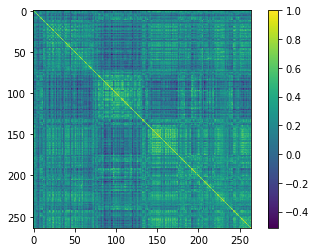

In [99]:
import matplotlib.pyplot as plt

plt.imshow(emoid_p[1])
plt.colorbar()
plt.show()

In [369]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [370]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

In [221]:
print(torch.mean(nback_p_t[0:2],dim=1))
print(torch.mean(emoid_p_t[0:2],dim=1))

tensor([ 0.0997, -0.0401], device='cuda:0')
tensor([-0.0564, -0.0477], device='cuda:0')


In [14]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [15]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [8]:
ageG_t = torch.zeros(age_t.numel(), 3).float().cuda()
borders = 12*np.array([8,14,18,24])

for j in range(age_t.numel()):
    for i in range(3):
        if age_t[j] >= borders[i] and age_t[j] < borders[i+1]:
            ageG_t[j,i] = 1
            break

print('Complete')

Complete


In [104]:
import torch

import torch.nn.functional as F
import torch.nn


class Connectome_Filter_Block(torch.nn.Module):
    
    '''Connectome Filter Block'''

    def __init__(self, n_filt, planes, input_ex, bias=False):
       
        super(Connectome_Filter_Block, self).__init__() #initialize
       
        self.d = input_ex.size(3) 
        self.in_planes = input_ex.size(1)
        
        self.cnn1 = torch.nn.Conv2d(n_filt,planes,(1,self.d),bias=bias).float().cuda() #row 
        self.cnn2 = torch.nn.Conv2d(n_filt,planes,(self.d,1),bias=bias).float().cuda() #column

        
    def forward(self, x, l, g_flag):
        
        '''
        Input : 
            x -> rs-fMRI connectome
            l -> DTI Laplacian
            g_flag -> graph filtering on
        '''
        
        if g_flag: #graph pre-filtering if True
            x = torch.matmul(l,x) 
        
        r = self.cnn1(x) #row filtering
        c = self.cnn2(x) #column filterning
        
        nd = list(r.shape)
        nd[3] = self.d
        a = r.expand(*nd) + c.expand(*nd)
        
        return a
    
class M_GCN(torch.nn.Module):
    
    def __init__(self, input_ex, num_classes):
        super(M_GCN, self).__init__()
        
        self.in_planes = input_ex.size(1)
        self.d = input_ex.size(3)
        
        self.cf_1 = Connectome_Filter_Block(1,8,input_ex,bias=True)      
        self.ef_1 = torch.nn.Conv2d(8,1,(1,self.d)).float().cuda()
        self.nf_1 = torch.nn.Conv2d(1,32,(self.d,1)).float().cuda()
        
        #ANN for regression
        self.dense1 = torch.nn.Linear(32,40).float().cuda()
        self.dense2 = torch.nn.Linear(40,num_classes).float().cuda()
        
    def forward(self, x, l, g_f):

        out = self.cf_1(x, l, g_f)

        if g_f:  # graph filtering     
            out = torch.matmul(l,out) # graph filtering
            
        out = self.ef_1(out)
       
        if g_f:  # graph filtering     
            out = torch.matmul(l,out)
       
        out = self.nf_1(out)
     
        #regression
        out = out.reshape(out.shape[0], -1)    
        out = F.relu(self.dense1(out))
        out = self.dense2(out)
        
        return out
    
def init_weights(m):
    
    if type(m) == torch.nn.Linear:
            
            torch.nn.init.xavier_normal(m.weight, gain=torch.nn.init.calculate_gain('relu'))
            m.bias.data.fill_(1e-02)
            
class Guys(torch.nn.Module):
    def __init__(self, input_ex, num_classes, nTgt, dp=0.5):
        super(Guys, self).__init__()
        self.mgcn = []
        for i in range(nTgt):
            self.mgcn.append(M_GCN(input_ex, num_classes))
        self.mgcn = nn.ModuleList(self.mgcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            res.append(self.mgcn[i](x[:,i:i+1,:,:], None, False).squeeze())
        return res
            
print('Complete')

Complete


In [367]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(263),40).float().cuda())
            self.gcn.append(DenseGCNConv(40,1).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(arith(263),40).float().cuda())
            self.lin.append(nn.Linear(40,1).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 500
thresh = 100

para = [nback_p_t, emoid_p_t]
# para = [nback_pp_t, emoid_pp_t]
rmse = []

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    gcn0 = GCN(2, 0.5) #Guys(X, 2, 2, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4) # 2e-4

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    val = age_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn0(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0))}')
            lossV = validate(gcn0, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0 = validate(gcn0, X, val, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])
    
print(time.time()-t)

epoch 0 loss=34361.1171875
New best validation epoch 0 loss=165.83099365234375
epoch 500 loss=2112.42333984375
New best validation epoch 500 loss=50.11949157714844
epoch 1000 loss=1856.800537109375
New best validation epoch 1000 loss=47.22422409057617
epoch 1500 loss=1555.83544921875
New best validation epoch 1500 loss=43.458805084228516
epoch 2000 loss=1273.83740234375
New best validation epoch 2000 loss=39.360042572021484
epoch 2500 loss=1069.941650390625
New best validation epoch 2500 loss=35.947021484375
epoch 3000 loss=929.291259765625
New best validation epoch 3000 loss=33.5795783996582
epoch 3500 loss=811.0887451171875
New best validation epoch 3500 loss=31.578100204467773
epoch 4000 loss=699.1104736328125
New best validation epoch 4000 loss=29.588212966918945
epoch 4500 loss=577.700439453125
New best validation epoch 4500 loss=28.18621826171875
epoch 5000 loss=472.548583984375
New best validation epoch 5000 loss=26.28423500061035
epoch 5500 loss=385.123046875
New best validatio

KeyboardInterrupt: 

In [94]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

32.70131301879883
38.176483154296875
34.913089752197266
34.645816802978516
38.55860137939453
33.7550163269043
35.57914352416992
33.40127182006836
31.947969436645508
36.07362747192383
---
34.975233268737796


In [494]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
        self.ln = nn.LayerNorm((nTgts, nback_p_t.shape[1])).cuda()
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 100
pPeriod = 5
thresh = 0.3

para = [nback_p_t, emoid_p_t]
rmse = []

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    sim = LatSim(len(para), 0.5, 0.1, 'same')
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) # 1e-4 age, gender; 1e-5 wrat

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])
    
#     a = gen_t[trainIdcs][:,0:1]
#     b = gen_t[trainIdcs][:,1:2]
#     c = gen_t[trainIdcs][:,2:3]
#     eTgt = mask(a@a.T+b@b.T)
#     eTgt[eTgt == 0] = float('-inf')
#     eTgt = F.softmax(eTgt, dim=1)

    var = gen_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, es = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        avgE = torch.mean(torch.stack(es), dim=0)
        loss0 = 0
        loss1 = torch.tensor(0).float().cuda()
        for r,e in zip(res + [avg], es + [avgE]):
            loss0 += ceLoss(r, var[trainIdcs])
#             loss1 += torch.mean(-e*torch.log(eTgt+1e-10)-eTgt*torch.log(e+1e-10))/2
        loss0 = loss0/(len(res)+1)
        loss1 = loss1/(len(res)+1)
        loss = torch.stack([loss0, loss1])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1))}')
            lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss0 = validate(sim, X, var, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])
    
    Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
    Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

    print(Y0.shape)
    print(Y1.shape)

    idcs = torch.argsort(age_t)
    Y0sort = Y0[idcs,:,:]
    Y1sort = Y1[idcs,:,:]

    Yparts = []
    step = 100

    for Y in [Y0sort, Y1sort]:
        parts = []
        for j in range(0,40000,step):
            if j >= Y.shape[1]:
                break
            part = Y[:,j:j+step,:]
            subConnSim = torch.einsum('abc,dbc->adb', part, part)
            subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
            parts.append(subConnR.detach().cpu().numpy())

        parts = np.concatenate(parts)
        Yparts.append(parts)

    Yparts = np.stack(Yparts)

    with open(f'../../Work/LatentSim/IndividualConnTopDiscrimination/GenderTop{i}.pkl', 'wb') as f:
        pickle.dump(Yparts, f)
    
    print('Complete')
    
print(time.time()-t)

epoch 0 loss=(0.6926988363265991, 0.0)
New best validation epoch 0 loss=0.6129032373428345
epoch 5 loss=(0.5933148860931396, 0.0)
New best validation epoch 5 loss=0.7258064150810242
epoch 10 loss=(0.44666123390197754, 0.0)
New best validation epoch 10 loss=0.774193525314331
epoch 15 loss=(0.37461838126182556, 0.0)
New best validation epoch 15 loss=0.7903225421905518
epoch 20 loss=(0.34259986877441406, 0.0)
epoch 25 loss=(0.329735666513443, 0.0)
epoch 30 loss=(0.322519987821579, 0.0)
epoch 35 loss=(0.31737351417541504, 0.0)
epoch 40 loss=(0.3165018558502197, 0.0)
epoch 45 loss=(0.3163524270057678, 0.0)
epoch 50 loss=(0.315248966217041, 0.0)
epoch 55 loss=(0.31481701135635376, 0.0)
New best validation epoch 55 loss=0.8064515590667725
epoch 60 loss=(0.31362470984458923, 0.0)
epoch 65 loss=(0.3135177791118622, 0.0)
epoch 70 loss=(0.3136845827102661, 0.0)
epoch 75 loss=(0.3134593963623047, 0.0)
epoch 80 loss=(0.31348904967308044, 0.0)
epoch 85 loss=(0.3134375214576721, 0.0)
epoch 90 loss=(0

epoch 50 loss=(0.3189043402671814, 0.0)
epoch 55 loss=(0.3157918453216553, 0.0)
epoch 60 loss=(0.3160203993320465, 0.0)
epoch 65 loss=(0.3144382834434509, 0.0)
New best validation epoch 65 loss=0.8548386693000793
epoch 70 loss=(0.3144536018371582, 0.0)
epoch 75 loss=(0.31419438123703003, 0.0)
epoch 80 loss=(0.31388866901397705, 0.0)
epoch 85 loss=(0.31409797072410583, 0.0)
epoch 90 loss=(0.31462547183036804, 0.0)
epoch 95 loss=(0.313679575920105, 0.0)
epoch 99 loss=(0.3146470785140991, 0.0)
Finished training
6 0.8064515590667725
torch.Size([620, 34716, 2])
torch.Size([620, 34716, 2])
Complete
epoch 0 loss=(0.6907857656478882, 0.0)
New best validation epoch 0 loss=0.6290322542190552
epoch 5 loss=(0.6081118583679199, 0.0)
New best validation epoch 5 loss=0.7419354915618896
epoch 10 loss=(0.46773406863212585, 0.0)
New best validation epoch 10 loss=0.8225806355476379
epoch 15 loss=(0.38234943151474, 0.0)
New best validation epoch 15 loss=0.8548386693000793
epoch 20 loss=(0.3464996814727783

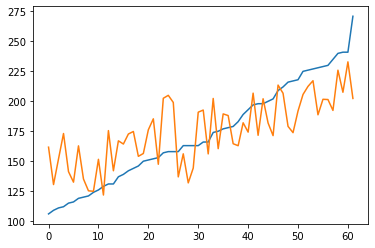

In [452]:
import matplotlib.pyplot as plt

res, _ = sim(X, var, testIdcs)
avg = torch.mean(torch.stack(res), dim=0)

idcs = torch.argsort(var[testIdcs])
avg = avg[testIdcs][idcs]

plt.plot(var[testIdcs][idcs].detach().cpu().numpy())
plt.plot(avg.detach().cpu().numpy())
plt.show()

In [495]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

0.8870967626571655
0.8064515590667725
0.8225806355476379
0.8548386693000793
0.8064515590667725
0.8064515590667725
0.8064515590667725
0.774193525314331
0.8548386693000793
0.7580645084381104
---
0.8177419006824493


In [257]:
Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

print(Y0.shape)
print(Y1.shape)

idcs = torch.argsort(age_t)
Y0sort = Y0[idcs,:,:]
Y1sort = Y1[idcs,:,:]

Yparts = []
step = 100

for Y in [Y0sort, Y1sort]:
    parts = []
    for i in range(0,40000,step):
        if i >= Y.shape[1]:
            break
        part = Y[:,i:i+step,:]
        subConnSim = torch.einsum('abc,dbc->adb', part, part)
        subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
        parts.append(subConnR.detach().cpu().numpy())

    parts = np.concatenate(parts)
    Yparts.append(parts)
    
Yparts = np.stack(Yparts)

with open(f'../../Work/LatentSim/IndividualConnTopDiscrimination/{name}.pkl', 'wb') as f:
    pickle.dump(Yparts, f)
    
print('Complete')

torch.Size([620, 34716, 2])
torch.Size([620, 34716, 2])
Complete


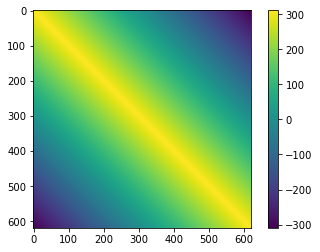

In [119]:
import matplotlib.pyplot as plt

mat0 = torch.arange(620).unsqueeze(1)
mat1 = torch.arange(620).unsqueeze(0)
mat = 310-torch.abs(mat0-mat1).float().cuda()

plt.imshow(mat.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [13]:
def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

def heatmaps(cuda):
    ht = []
    for i in range(cuda.shape[0]):
        ht.append(heatmap(cuda[i]))
    return np.stack(ht)

print('Complete')

Complete


In [34]:
import torch.autograd

gcn0.eval()

X.requires_grad = True
res = gcn0(X, age_t)
loss = mseLoss(res[0], age_t)
loss.backward()

ht = heatmaps(X.grad[:,0,:])
print(ht.shape)

X.grad = None

NameError: name 'gcn0' is not defined

In [178]:
mod = 1

with torch.no_grad():
    st0 = X[:,mod,:]*sim.masks[mod][:,0].unsqueeze(0)
    st1 = X[:,mod,:]*sim.masks[mod][:,1].unsqueeze(0)
    
st0 = heatmaps(st0)
st1 = heatmaps(st1)
print(st0.shape)
print(st1.shape)

(620, 264, 264)
(620, 264, 264)


In [187]:
def gradGroup(ht, y, low, high):
    hts = []
    for i in range(len(y)):
        if y[i] >= low and y[i] < high:
            hts.append(ht[i])
    hts = np.stack(hts)
    return hts
    
stYoung = gradGroup(st0, age, 0, 120)
stOld = gradGroup(st0, age, 20*12, 100*12)

print(stYoung.shape)
print(stOld.shape)

(47, 264, 264)
(35, 264, 264)


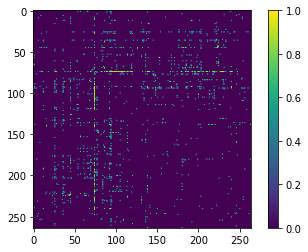

In [188]:
import matplotlib.pyplot as plt

def highlight(m, pct=0.05, top=True):
    s = m.shape
    mf = m.flatten()
    k = int(pct*len(mf))
    if k >= len(mf):
        k = len(mf)-1
    if top:
        ind = np.argpartition(mf, -k)[-k:]
    else:
        ind = np.argpartition(mf, k)[:k]
    mfc = np.zeros(len(mf))
    mfc[ind] = 1
    mfc = mfc.reshape(s)
    return mfc

plt.imshow(highlight(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), pct=0.02, top=True))
plt.colorbar()
plt.show()

In [164]:
big = np.sum(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), axis=0)
np.sort(big)

array([-0.09929131, -0.04897132, -0.04472183, -0.04434179, -0.04117358,
       -0.04051899, -0.03915526, -0.03727047, -0.03703854, -0.03671807,
       -0.03329211, -0.03275497, -0.03170017, -0.02900913, -0.02900497,
       -0.02882973, -0.02811228, -0.02769388, -0.0271041 , -0.02702304,
       -0.02682079, -0.02535298, -0.02482679, -0.02409301, -0.02318976,
       -0.02304742, -0.02291244, -0.02273415, -0.02206707, -0.02115995,
       -0.02024821, -0.02016954, -0.01982425, -0.01836563, -0.01815567,
       -0.01764317, -0.01706735, -0.01550612, -0.01546351, -0.01500905,
       -0.01476049, -0.0146    , -0.01414149, -0.01359345, -0.01357858,
       -0.01291749, -0.01257225, -0.01201024, -0.01179734, -0.01107455,
       -0.01096524, -0.01054496, -0.00961884, -0.00961255, -0.00946262,
       -0.00934104, -0.00923104, -0.0090726 , -0.00894678, -0.00792893,
       -0.00790995, -0.00748322, -0.00743905, -0.00728274, -0.00726925,
       -0.00712217, -0.00661963, -0.00645348, -0.00628533, -0.00

In [158]:
np.argsort(big)

array([ 74,  57,  20,  37, 241, 193, 145, 195,  39, 122, 182,  79, 197,
       164, 159, 128, 222,  19, 179, 155, 117, 250, 121,  59, 167, 132,
       252, 112,  64, 244,  55,  76, 178, 133, 218,  47, 234, 188,  18,
       163,  24, 242,  80, 207, 208, 221, 214, 138, 183, 141, 166, 192,
       238,  29, 174,  70,  58,  77, 210, 194,  51, 149, 175,  81,  22,
       199, 165, 129, 126,  14, 143, 104,  93, 142, 253, 144,  60, 114,
        85,  27, 171,  63, 147, 209, 259, 108,  86,  34, 140,  41, 125,
        31, 202, 261, 135, 211, 152, 162, 196,  98, 203,  33, 254, 216,
       161,   8, 127,  56, 110,  21, 170, 240,  17, 262, 228,  83,  88,
        54,   7, 130, 107, 109, 111, 245, 181, 154, 102,  73, 153, 168,
       124,  84, 101,  87,  40,  11,  97, 233, 115, 116, 118, 263,  44,
       173, 235, 257, 251, 230, 150,  10, 160, 146, 260, 239,  42, 204,
        12,  15,  66,   3, 169,  89, 232,  36, 223,  96,   2, 224,   1,
        72, 205, 136, 243, 105, 191, 100, 113,  67,  75, 217, 23

In [61]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])
        
last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


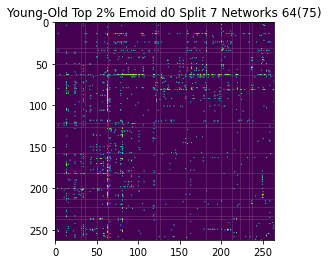

In [189]:
def rearrange(p,idcs):
    return p[:,idcs][idcs]

fig, ax = plt.subplots()

ax.imshow(rearrange(highlight(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), pct=0.02, top=True), revMap2))
for b in borders1:
    ax.plot([0,263],[b,b],color='pink',linewidth=0.5,alpha=0.3)
    ax.plot([b,b],[0,263],color='pink',linewidth=0.5,alpha=0.3)
ax.set_xlim(0,263)
ax.set_ylim(262,0)
ax.set_title('Young-Old Top 2% Emoid d0 Split 7 Networks 64(75)')
    
fig.show()
fig.savefig('../../Work/LatentSim/EmoidSplit7d074.png', format='png', bbox_inches='tight')

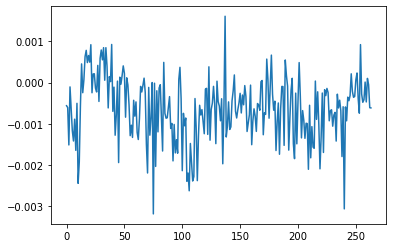

In [51]:
plt.plot((np.mean(stYoung, axis=0)-np.mean(stOld, axis=0))[74].T)
plt.show()

In [98]:
(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0))[75,77]

0.004962707892730641

In [117]:
pYoung = gradGroup(nback_p, age, 0, 120)
pOld = gradGroup(nback_p, age, 20*12, 100*12)

print(pYoung.shape)
print(pOld.shape)

(47, 264, 264)
(35, 264, 264)


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


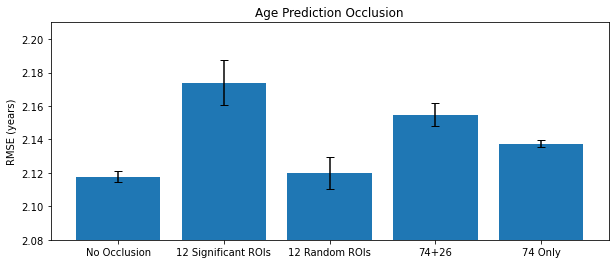

In [215]:

base = np.array([2.11495959, 2.114336936, 2.121793159, 2.120340157, 2.121212546,
                2.113928016])
target = np.array([2.159177987, 2.195234044, 2.174582672, 2.184550174, 2.15519913, 
                   2.16735212, 2.182058303])
random = np.array([2.12082723, 2.104936107, 2.119658629, 2.11539259, 2.129641485, 
                   2.123271751, 2.135961103, 2.110342566])
mini2 = np.array([2.148108244, 2.161557738])
mini1 = np.array([2.136369244, 2.135416079, 2.14074839])

mu = [np.mean(x) for x in [base, target, random, mini2, mini1]]
sigma = [np.std(x) for x in [base, target, random, mini2, mini1]]

fig, ax = plt.subplots(figsize=(10,4))

ax.bar(('No Occlusion', '12 Significant ROIs', '12 Random ROIs', '74+26', '74 Only'), mu, capsize=4, yerr=sigma)
ax.set_ylim([2.08,2.21])
ax.set_title('Age Prediction Occlusion')
ax.set_ylabel('RMSE (years)')

fig.show()
fig.savefig('../../Work/LatentSim/Occlusion.png', format='png', bbox_inches='tight')

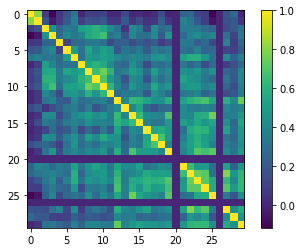

In [45]:
import matplotlib.pyplot as plt

plt.imshow(nback_p[2,:30,:30])
plt.colorbar()
plt.show()